# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

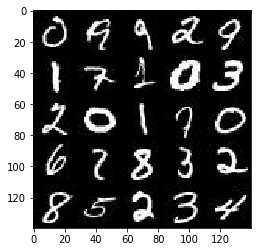

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

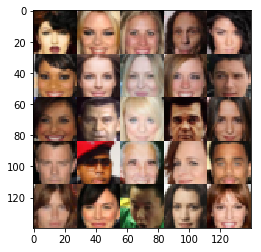

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learn_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # Leaky RELU
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256 now
        
        flatten = tf.reshape(x3, (-1, 4*4*256))
        # Logits and tanh output
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now

        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x5 now

        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, is_train=True):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train, alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, training=is_train)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, training=is_train)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape[0], data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2, is_train=True)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_d_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_g_loss = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 1.1256
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 2.5822
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.7003
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 1.4955
Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 1.1449
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 2.4805
Epoch 1/2... Discriminator Loss: 0.9538... Generator Loss: 1.8792
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.7847


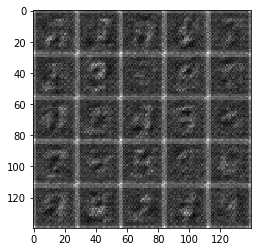

Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 1.3811
Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 0.9350... Generator Loss: 1.3939
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 1.0965
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 1.0324
Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 1.4241
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 2.5202
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.8852
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.2482


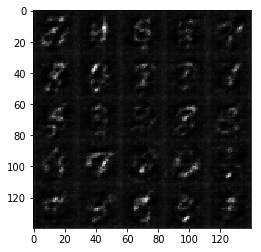

Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 2.6663
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.6220
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 1.7368
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 1.6130
Epoch 1/2... Discriminator Loss: 0.8535... Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 1.5018
Epoch 1/2... Discriminator Loss: 0.7740... Generator Loss: 1.9744
Epoch 1/2... Discriminator Loss: 0.7505... Generator Loss: 1.3853
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 1.1927


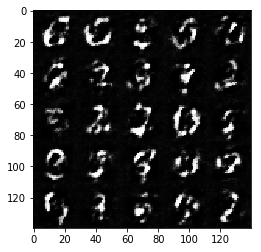

Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 1.3725
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.2680
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 1.9584
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.9745
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 1.6515
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.4351
Epoch 1/2... Discriminator Loss: 0.7667... Generator Loss: 2.4178
Epoch 1/2... Discriminator Loss: 0.6718... Generator Loss: 1.9702
Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 1.6317


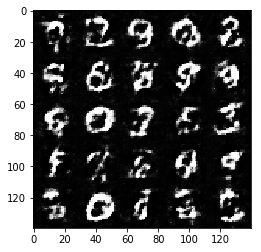

Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 1.5973
Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.4563
Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 2.0038
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.5169
Epoch 1/2... Discriminator Loss: 0.7097... Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 2.2320
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 2.8438
Epoch 1/2... Discriminator Loss: 0.9003... Generator Loss: 0.9878
Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.1253


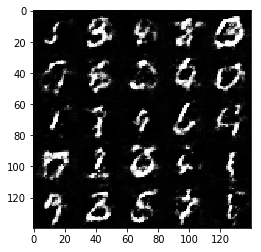

Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 2.1291
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 3.2104
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.9142
Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 1.9976
Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 1.7816
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 2.0241
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 1.6415
Epoch 1/2... Discriminator Loss: 0.9745... Generator Loss: 0.9496
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.3542
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 2.3259


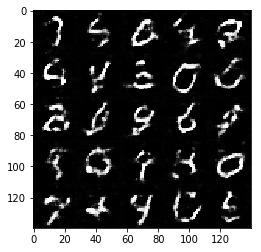

Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 0.9450... Generator Loss: 1.0577
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.7612
Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 1.3368
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 2.1168
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.1502
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.2432
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 1.6410


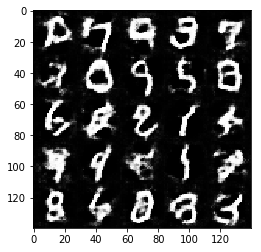

Epoch 1/2... Discriminator Loss: 0.9030... Generator Loss: 1.3457
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 1.4938
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.3602
Epoch 1/2... Discriminator Loss: 1.0306... Generator Loss: 1.5398
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.8161
Epoch 1/2... Discriminator Loss: 0.8991... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.8604
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 2.2012
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 0.9855


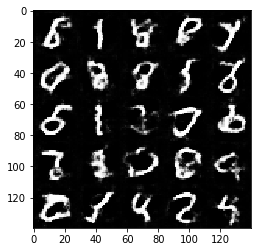

Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 1.9715
Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 1.8562
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.1933
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 0.7404
Epoch 1/2... Discriminator Loss: 0.9781... Generator Loss: 1.4126
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 1.6332
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.3737
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 0.7421


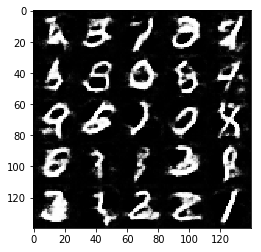

Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.4980
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 1.5226
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 1.4958
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.2714
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 1.2372
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 1.0785
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 0.9446


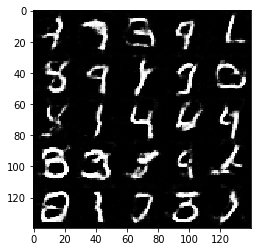

Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 1.1849
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.3161
Epoch 2/2... Discriminator Loss: 0.9408... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 1.0666
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 1.6028
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 1.2346
Epoch 2/2... Discriminator Loss: 0.8700... Generator Loss: 1.4125
Epoch 2/2... Discriminator Loss: 0.9305... Generator Loss: 1.4118
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 1.2657


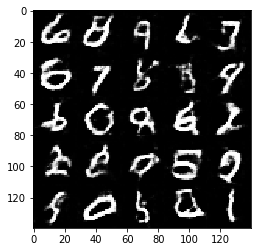

Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.6275
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.4770
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 0.8989
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 1.4473
Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.2045


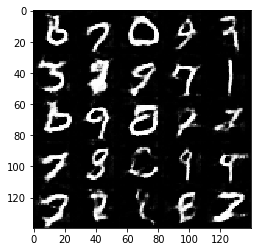

Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 0.9187
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.1504
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 2.0991
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.0122
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.4607


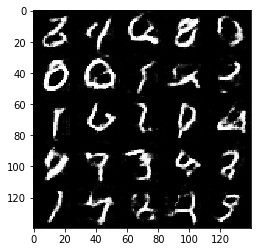

Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.2245
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 1.0407
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 1.9597
Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 1.6927
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 1.8657


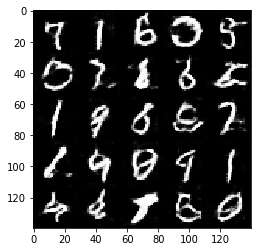

Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 1.1952
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 1.0383
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 1.6597
Epoch 2/2... Discriminator Loss: 1.4780... Generator Loss: 0.5213
Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 1.7290
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 1.1528
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 1.2952
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.3823


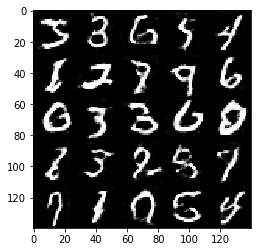

Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 1.5067
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 1.2722
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.6120
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.5249
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 1.4247
Epoch 2/2... Discriminator Loss: 0.9532... Generator Loss: 1.0785
Epoch 2/2... Discriminator Loss: 1.0709... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.8262


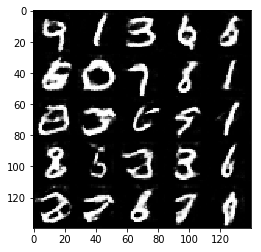

Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.0323
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 0.9009... Generator Loss: 1.6732
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.2584
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.5352
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.4301
Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 2.0347
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 1.3785
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.9052


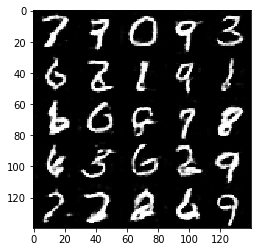

Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.1295
Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 1.0462
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 1.1208
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 1.1611
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 0.9383
Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 0.8114


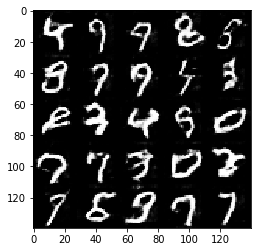

Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.1391
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 1.1606
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.3426
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.0110
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 1.3403
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 1.0478


In [12]:
batch_size = 64
z_dim = 64
learning_rate = 0.0001
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 1.9954
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 2.3310
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 3.0143
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.3860
Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 3.9022
Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 4.3524
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 4.5365
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 4.4393
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 4.3483
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 4.5900


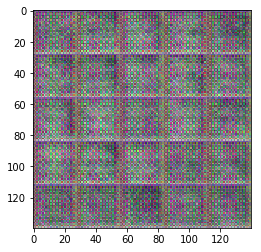

Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 3.0985
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.9652
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 7.2787
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 4.3027
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 2.1205
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 3.3843
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 2.3063
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 4.2082
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.4124


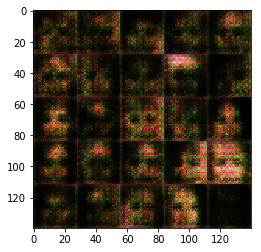

Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.8059
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.6491
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 2.7562
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.8424
Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.8514
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.5047


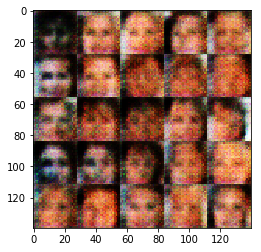

Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.6790
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.7384
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.6742


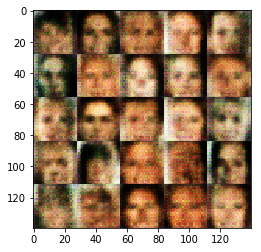

Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.9299
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.7794
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.5428
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.8182
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.7004
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.3729
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 2.0940


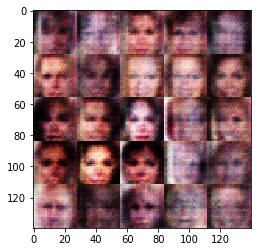

Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.7999
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 2.3506
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.6289
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.4264


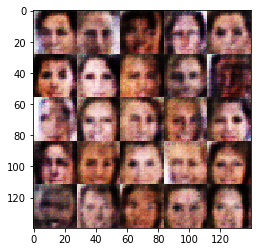

Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.3862
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.5113
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.4813
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.3379


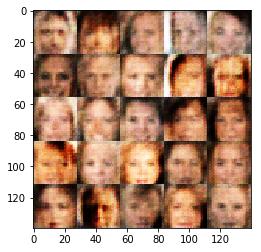

Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.3244
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.9279


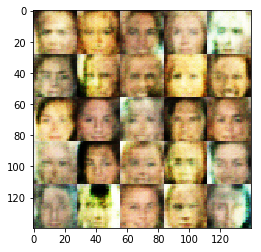

Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.4059
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.3397
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.3492
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.7440


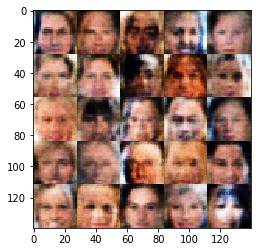

Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.2577


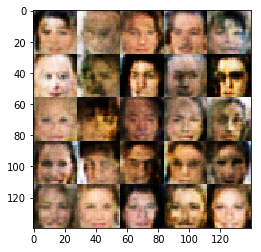

Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.8716
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.5385
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.3287
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.6896
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.3490


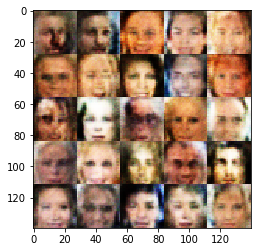

Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.8471


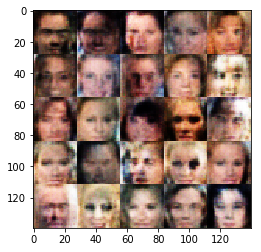

Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.6796
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.2036


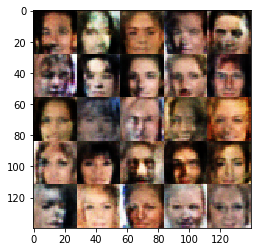

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.4098
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.7337
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 2.0415
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.5663
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.4261


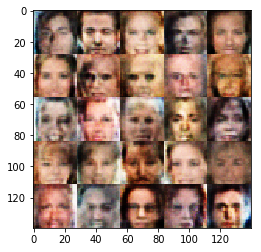

Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.3212
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.4183
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.5730


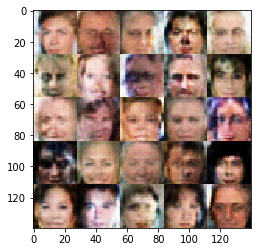

Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.4929
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 2.1014
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.5962
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.6396


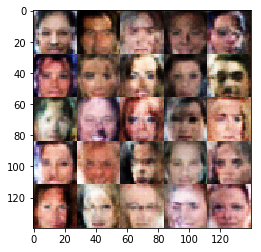

Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.6978
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.0196
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.5786
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 2.0628
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.1600


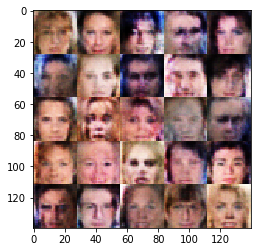

Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.4595
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 1.0809


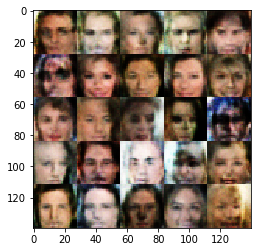

Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.6740
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.3638


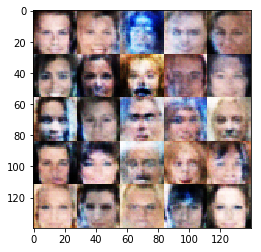

Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.3252


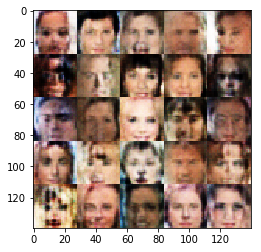

Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.7700
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.9639


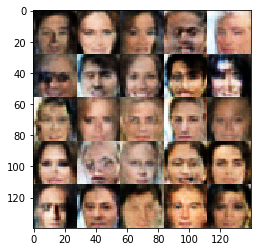

Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.6964
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 0.7501... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 2.3765


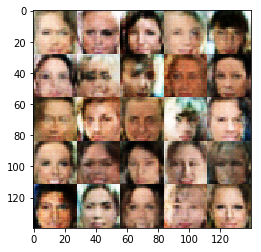

Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.8842
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 1.0317


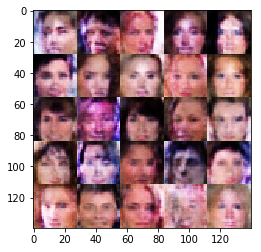

Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.4832
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.7917


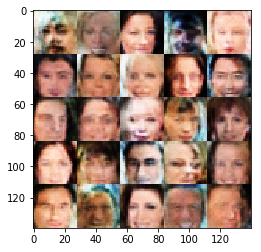

Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.2595


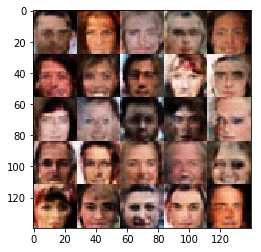

Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.3085
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.6007
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.3334


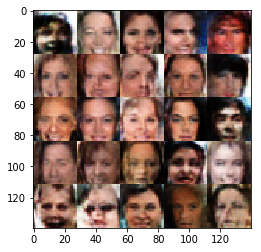

Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.3034
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.8405


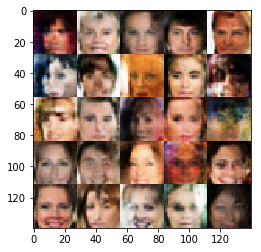

Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8391


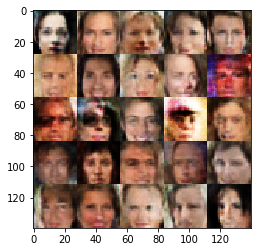

Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 2.1173
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.4645
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.8125


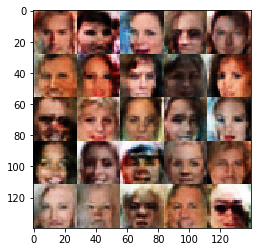

Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.7401
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.2394


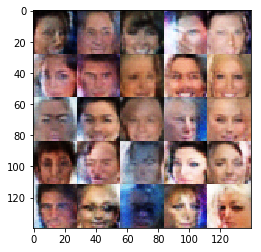

Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.2360
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.6928
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.9659


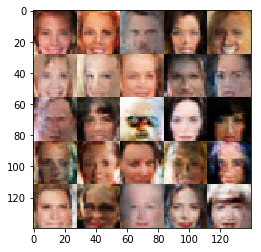

Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.4990
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.9241


In [13]:
batch_size = 64
z_dim = 64
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1
tf.reset_default_graph()
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.